# Load data

In [128]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
sns.set(style="whitegrid", palette="bright")

import os

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from google.colab import files
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!pip install pandas==1.5.3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 48.4 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.10.1 requires pandas<2.2.3dev0,>=2.0, but you have pandas 1.5.3 which is incompatible.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 1.5.3 which is incompatible.
mizani 0.11.4 requires pandas>=2.1.0, but you have pandas 1.5.3 which is incompatible.
plotnine 0.13.6 requires pandas<3.0.0,>=2.1.0, but you have pandas 1.5.3 which is incompatible.
xarray 2024.9.0 requires pandas>=2.1, but you have pandas 1.5.3 which is incompatible.


In [3]:
!pip install -U ppscore --no-deps # Update ppscore without updating its dependencies


  Preparing metadata (setup.py) ... done
  Created wheel for ppscore: filename=ppscore-1.3.0-py2.py3-none-any.whl size=13164 sha256=961b92858a07d417fca8ce67d3a59b8cc36d308d4651b086974bd6d827419de5
  Stored in directory: /root/.cache/pip/wheels/42/87/10/00056aa2d2624f1b9374db6a0d5245da9a3d87bdc9247c1a56
Successfully built ppscore


In [4]:
import ppscore as pps # Import ppscore

In [5]:
path = '/content/drive/My Drive/Colab Notebooks/EPAM DS foundations course/DS_module3/df_eda.csv'
df = pd.read_csv(path, sep=',')

pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

In [6]:
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,RainToday_encoded,RainTomorrow_encoded
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No,0.0,0.0
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No,0.0,0.0
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No,0.0,0.0
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No,0.0,0.0
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No,0.0,0.0


# Implementation summary

| # | Desc | Status |Comment|
|----|----|-----|-----|
|1| Feature Engineering | done|  Extracted month and season from date. Extracted meta from location:</br> lat&long, geozone, admin zone, elevation. |
|2| Imputation | done| I marked for considering removal those that had many losses: Evaporation, Cloud9am</br> and had no affect to target variable. impute missing values of those that are important Imputed features according to prev notes</br>and Sunshine and Cloud using KNN|
|3| Importance | done |I relied on Pearson and PPScore to identify important features.|
|4| handle outliers | done | hanlde outliers with capping: WindGustSpeed, RainFall, Evaporation |
|5| Encoding |  | Encode Wind Directions |
|6| Normalization |  |  |

# Feature engineering

### Other Feature engineering candidates:
*   impute missed data ( Evaporation, Sunshine, Cloud9am, and Cloud3pm ), apply appropriate imputation methods
*   temperature - calculate deltas of, + pers of change ( frost or heatwaves )
*   humidity variability, + pers
*   Lagged features -  yesterday's humidity, temperature
*   Rolling averages for the last week/3 days - for Temperature, Pressure, Humidity Averages. Could help to highlight longer-term trends.


## Location

In [7]:
cities = df['Location'].unique()
print(cities)

['Albury' 'BadgerysCreek' 'Cobar' 'CoffsHarbour' 'Moree' 'Newcastle'
 'NorahHead' 'NorfolkIsland' 'Penrith' 'Richmond' 'Sydney' 'SydneyAirport'
 'WaggaWagga' 'Williamtown' 'Wollongong' 'Canberra' 'Tuggeranong'
 'MountGinini' 'Ballarat' 'Bendigo' 'Sale' 'MelbourneAirport' 'Melbourne'
 'Mildura' 'Nhil' 'Portland' 'Watsonia' 'Dartmoor' 'Brisbane' 'Cairns'
 'GoldCoast' 'Townsville' 'Adelaide' 'MountGambier' 'Nuriootpa' 'Woomera'
 'Albany' 'Witchcliffe' 'PearceRAAF' 'PerthAirport' 'Perth' 'SalmonGums'
 'Walpole' 'Hobart' 'Launceston' 'AliceSprings' 'Darwin' 'Katherine'
 'Uluru']


Sicne there are a lot of Cities, I decided to find out some other grouping opportunities by location name:

In [8]:
path2 = '/content/drive/My Drive/Colab Notebooks/EPAM DS foundations course/DS_module3/cities_meta.csv'
cities_meta = pd.read_csv(path2)
cities_meta.set_index('City Name', inplace=True)
cities_meta.head()

,Administrative Region,Geographic Region,Climatic zone,Elevation Zone,Latitude,Longitude
City Name,,,,,,
Albury,New South Wales,Southeastern Australia,Temperate,Lowland,36.0740,146.9240
BadgerysCreek,New South Wales,Eastern Australia,Temperate,Lowland,33.8785,150.7605
Cobar,New South Wales,Eastern Australia,Semi-arid,Lowland,31.4980,145.8340
CoffsHarbour,New South Wales,Eastern Australia,Subtropical,Coastal,30.2986,153.1094
Moree,New South Wales,Eastern Australia,Semi-arid,Plain,29.4658,149.8418


In [12]:
print('Elevation Zone:', cities_meta['Elevation Zone'].unique())
print('Geographic Region:', cities_meta['Geographic Region'].unique())
print('Clim zones:', cities_meta['Climatic zone'].unique())

Elevation Zone: ['Lowland' 'Coastal' 'Plain' 'Coastal Plain' 'Island' 'Plateau'
 'High Mountain' 'Hilly']
Geographic Region: ['Southeastern Australia' 'Eastern Australia' 'External Territory'
 'Southern Australia' 'Northern Australia' 'Western Australia' 'Tasmania'
 'Central Australia']
Clim zones: ['Temperate' 'Semi-arid' 'Subtropical' 'Tropical' 'Mediterranean' 'Desert']


In [13]:
df['Georegion'] = df['Location'].map(cities_meta['Geographic Region'])
df['ElevationZone'] = df['Location'].map(cities_meta['Elevation Zone'])
df['ClimaticZone'] = df['Location'].map(cities_meta['Climatic zone'])
df['AdminReg'] = df['Location'].map(cities_meta['Administrative Region'])
df['Latitude'] = df['Location'].map(cities_meta['Latitude'])
df['Longitude'] = df['Location'].map(cities_meta['Longitude'])

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 141006 entries, 0 to 141005
Data columns (total 31 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Date                  141006 non-null  object 
 1   Location              141006 non-null  object 
 2   MinTemp               140731 non-null  float64
 3   MaxTemp               140816 non-null  float64
 4   Rainfall              139845 non-null  float64
 5   Evaporation           81313 non-null   float64
 6   Sunshine              74351 non-null   float64
 7   WindGustDir           132680 non-null  object 
 8   WindGustSpeed         132738 non-null  float64
 9   WindDir9am            132066 non-null  object 
 10  WindDir3pm            138181 non-null  object 
 11  WindSpeed9am          140416 non-null  float64
 12  WindSpeed3pm          139318 non-null  float64
 13  Humidity9am           139717 non-null  float64
 14  Humidity3pm           138061 non-null  float64
 15  

<ipython-input-63-b2acd1a3118b>:2: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:skyblue'` for the same effect.

  sns.countplot(data=df, x='Georegion', hue='RainTomorrow', color='skyblue')


<Axes: xlabel='Georegion', ylabel='count'>

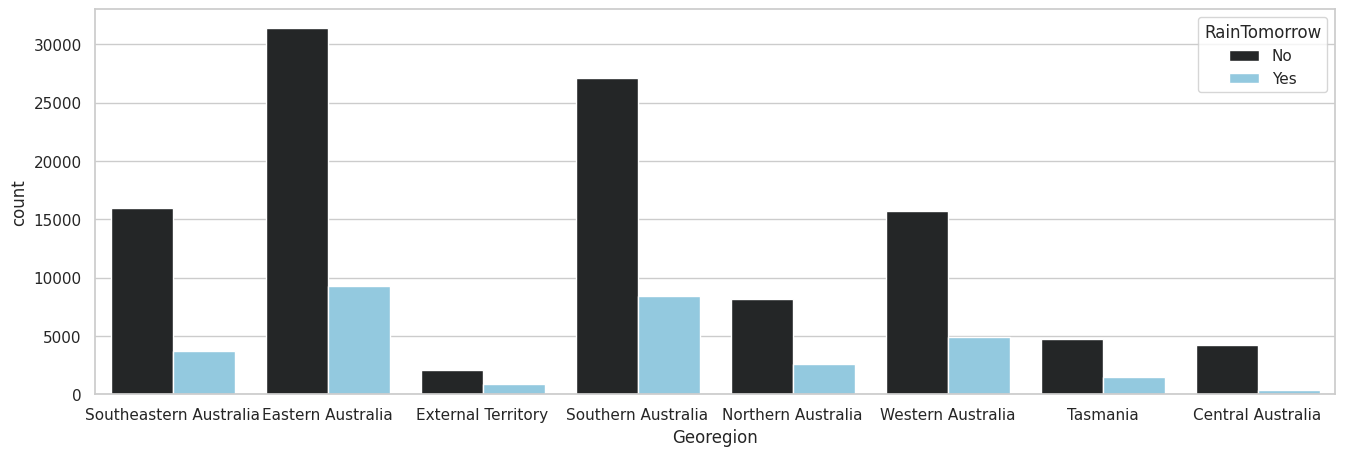

In [ ]:
plt.figure(figsize=(16, 5))
sns.countplot(data=df, x='Georegion', hue='RainTomorrow', color='skyblue')

<ipython-input-64-f306fb709201>:2: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:skyblue'` for the same effect.

  sns.countplot(data=df, x='ElevationZone', hue='RainTomorrow', color='skyblue')


<Axes: xlabel='ElevationZone', ylabel='count'>

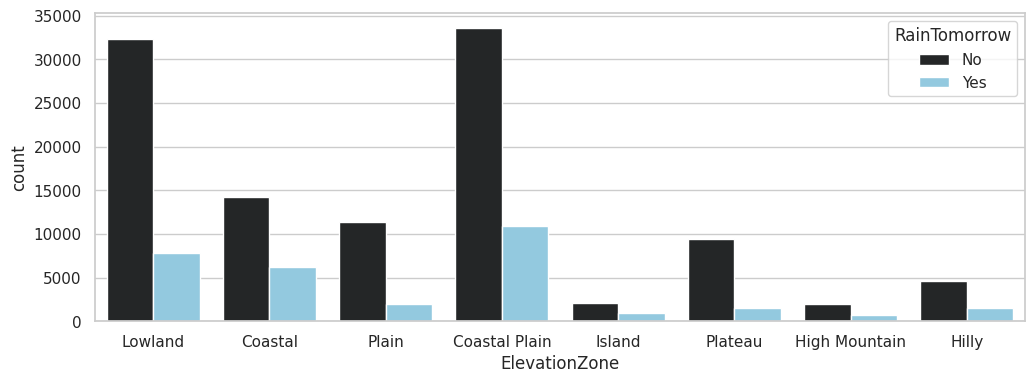

In [ ]:
plt.figure(figsize=(12, 4))
sns.countplot(data=df, x='ElevationZone', hue='RainTomorrow', color='skyblue')

<ipython-input-65-67d76a0c8823>:2: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:skyblue'` for the same effect.

  sns.countplot(data=df, x='AdminReg', hue='RainTomorrow', color='skyblue')


<Axes: xlabel='AdminReg', ylabel='count'>

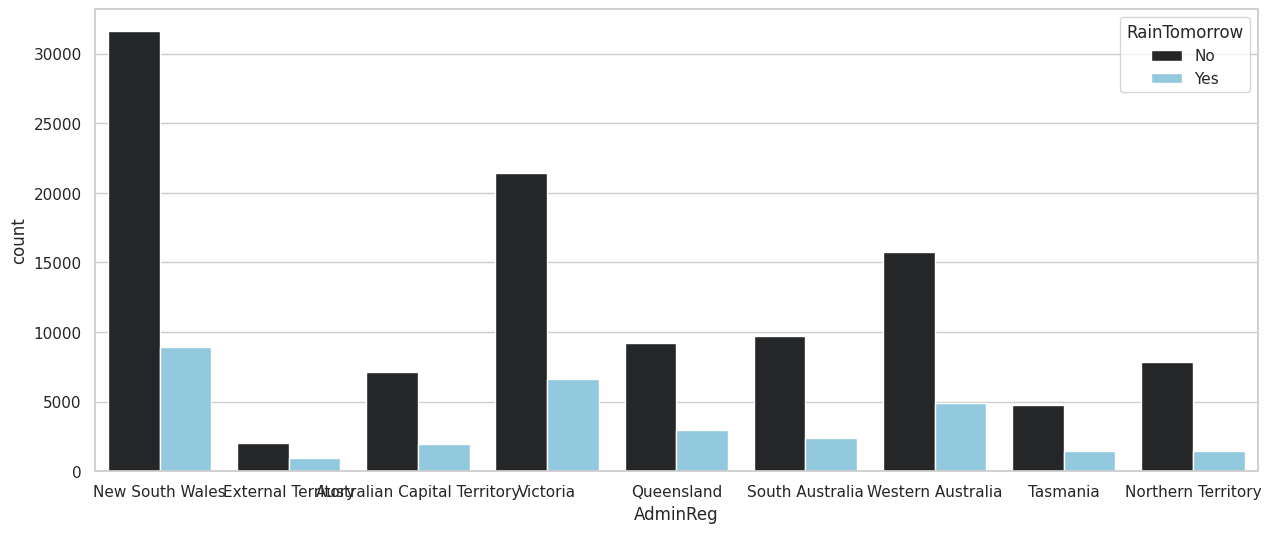

In [ ]:
plt.figure(figsize=(15, 6))
sns.countplot(data=df, x='AdminReg', hue='RainTomorrow', color='skyblue')

<ipython-input-66-880d3ff433b1>:2: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:skyblue'` for the same effect.

  sns.countplot(data=df, x='ClimaticZone', hue='RainTomorrow', color='skyblue')


<Axes: xlabel='ClimaticZone', ylabel='count'>

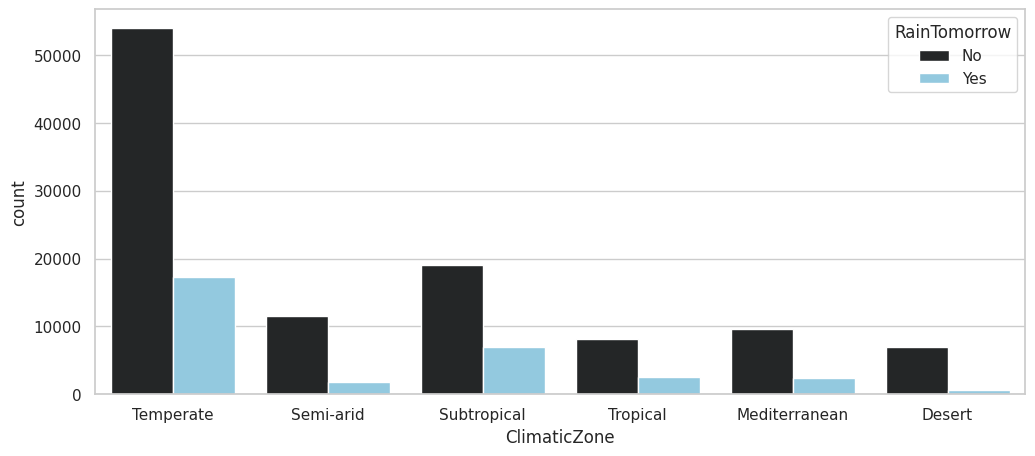

In [ ]:
plt.figure(figsize=(12, 5))
sns.countplot(data=df, x='ClimaticZone', hue='RainTomorrow', color='skyblue')

## Months and Seasons

In [15]:
df['Date'] = pd.to_datetime(df['Date'])
df['Month'] = df['Date'].dt.strftime('%B')

In [16]:
seasons = {
    'January': 'Winter',
    'February': 'Winter',
    'March': 'Spring',
    'April': 'Spring',
    'May': 'Spring',
    'June': 'Summer',
    'July': 'Summer',
    'August': 'Summer',
    'September': 'Autumn',
    'October': 'Autumn',
    'November': 'Autumn',
    'December': 'Winter'
}

df['Season'] = df['Month'].map(seasons)

In [17]:
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,RainToday_encoded,RainTomorrow_encoded,Georegion,ElevationZone,ClimaticZone,AdminReg,Latitude,Longitude,Month,Season
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No,0.0,0.0,Southeastern Australia,Lowland,Temperate,New South Wales,36.074,146.924,December,Winter
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No,0.0,0.0,Southeastern Australia,Lowland,Temperate,New South Wales,36.074,146.924,December,Winter
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No,0.0,0.0,Southeastern Australia,Lowland,Temperate,New South Wales,36.074,146.924,December,Winter
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No,0.0,0.0,Southeastern Australia,Lowland,Temperate,New South Wales,36.074,146.924,December,Winter
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No,0.0,0.0,Southeastern Australia,Lowland,Temperate,New South Wales,36.074,146.924,December,Winter


<ipython-input-22-8f6c609e00ea>:2: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:orange'` for the same effect.

  sns.countplot(data=df, x='Month', hue='RainTomorrow', color='orange')


<Axes: xlabel='Month', ylabel='count'>

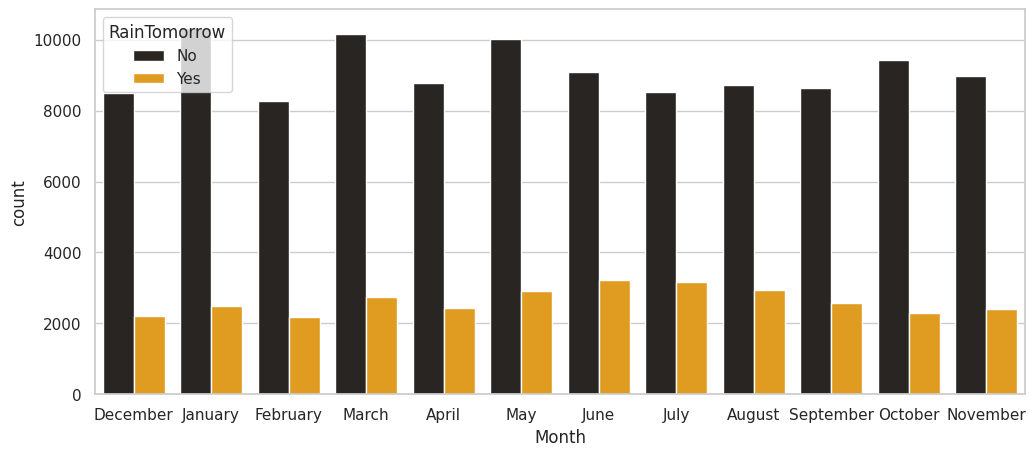

In [22]:
plt.figure(figsize=(12, 5))
sns.countplot(data=df, x='Month', hue='RainTomorrow', color='orange')

<Axes: xlabel='Month'>

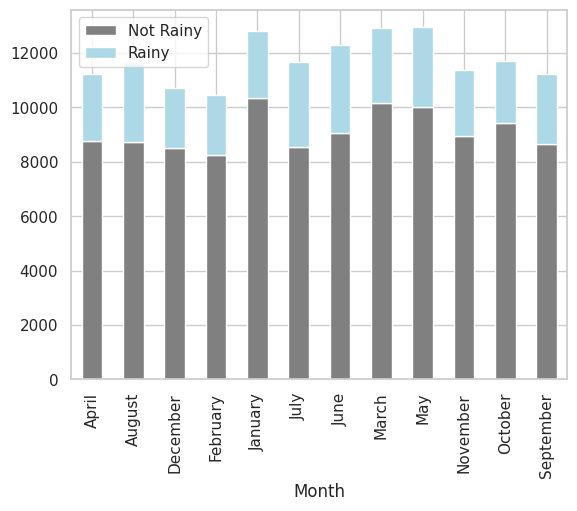

In [19]:
monthly_rain = df.groupby('Month')['RainTomorrow_encoded'].value_counts()
monthly_rain  = monthly_rain.unstack(fill_value=0)
# monthly_rain
monthly_rain.columns = ['Not Rainy', 'Rainy']
monthly_rain.plot(kind='bar', stacked=True, color=['gray', 'lightblue'])


In [ ]:
monthly_rain

,Not Rainy,Rainy
Month,,
April,8842,2462
August,8792,2970
December,8559,2250
February,8317,2207
January,10418,2498
July,8608,3171
June,9143,3244
March,10248,2779
May,10108,2941


<ipython-input-21-2f6c4aaa904c>:2: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:yellow'` for the same effect.

  sns.countplot(data=df, x='Season', hue='RainTomorrow', color='yellow')


<Axes: xlabel='Season', ylabel='count'>

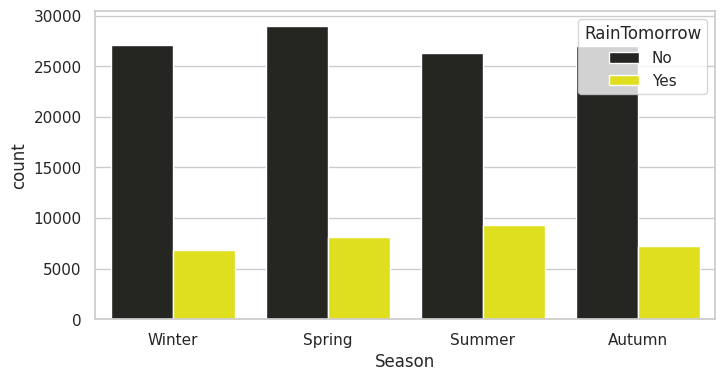

In [21]:
plt.figure(figsize=(8, 4))
sns.countplot(data=df, x='Season', hue='RainTomorrow', color='yellow')

# Importance

<ipython-input-67-1fa0ff3e5aee>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), linewidths=0.5, annot=True, cmap="coolwarm")


<Axes: >

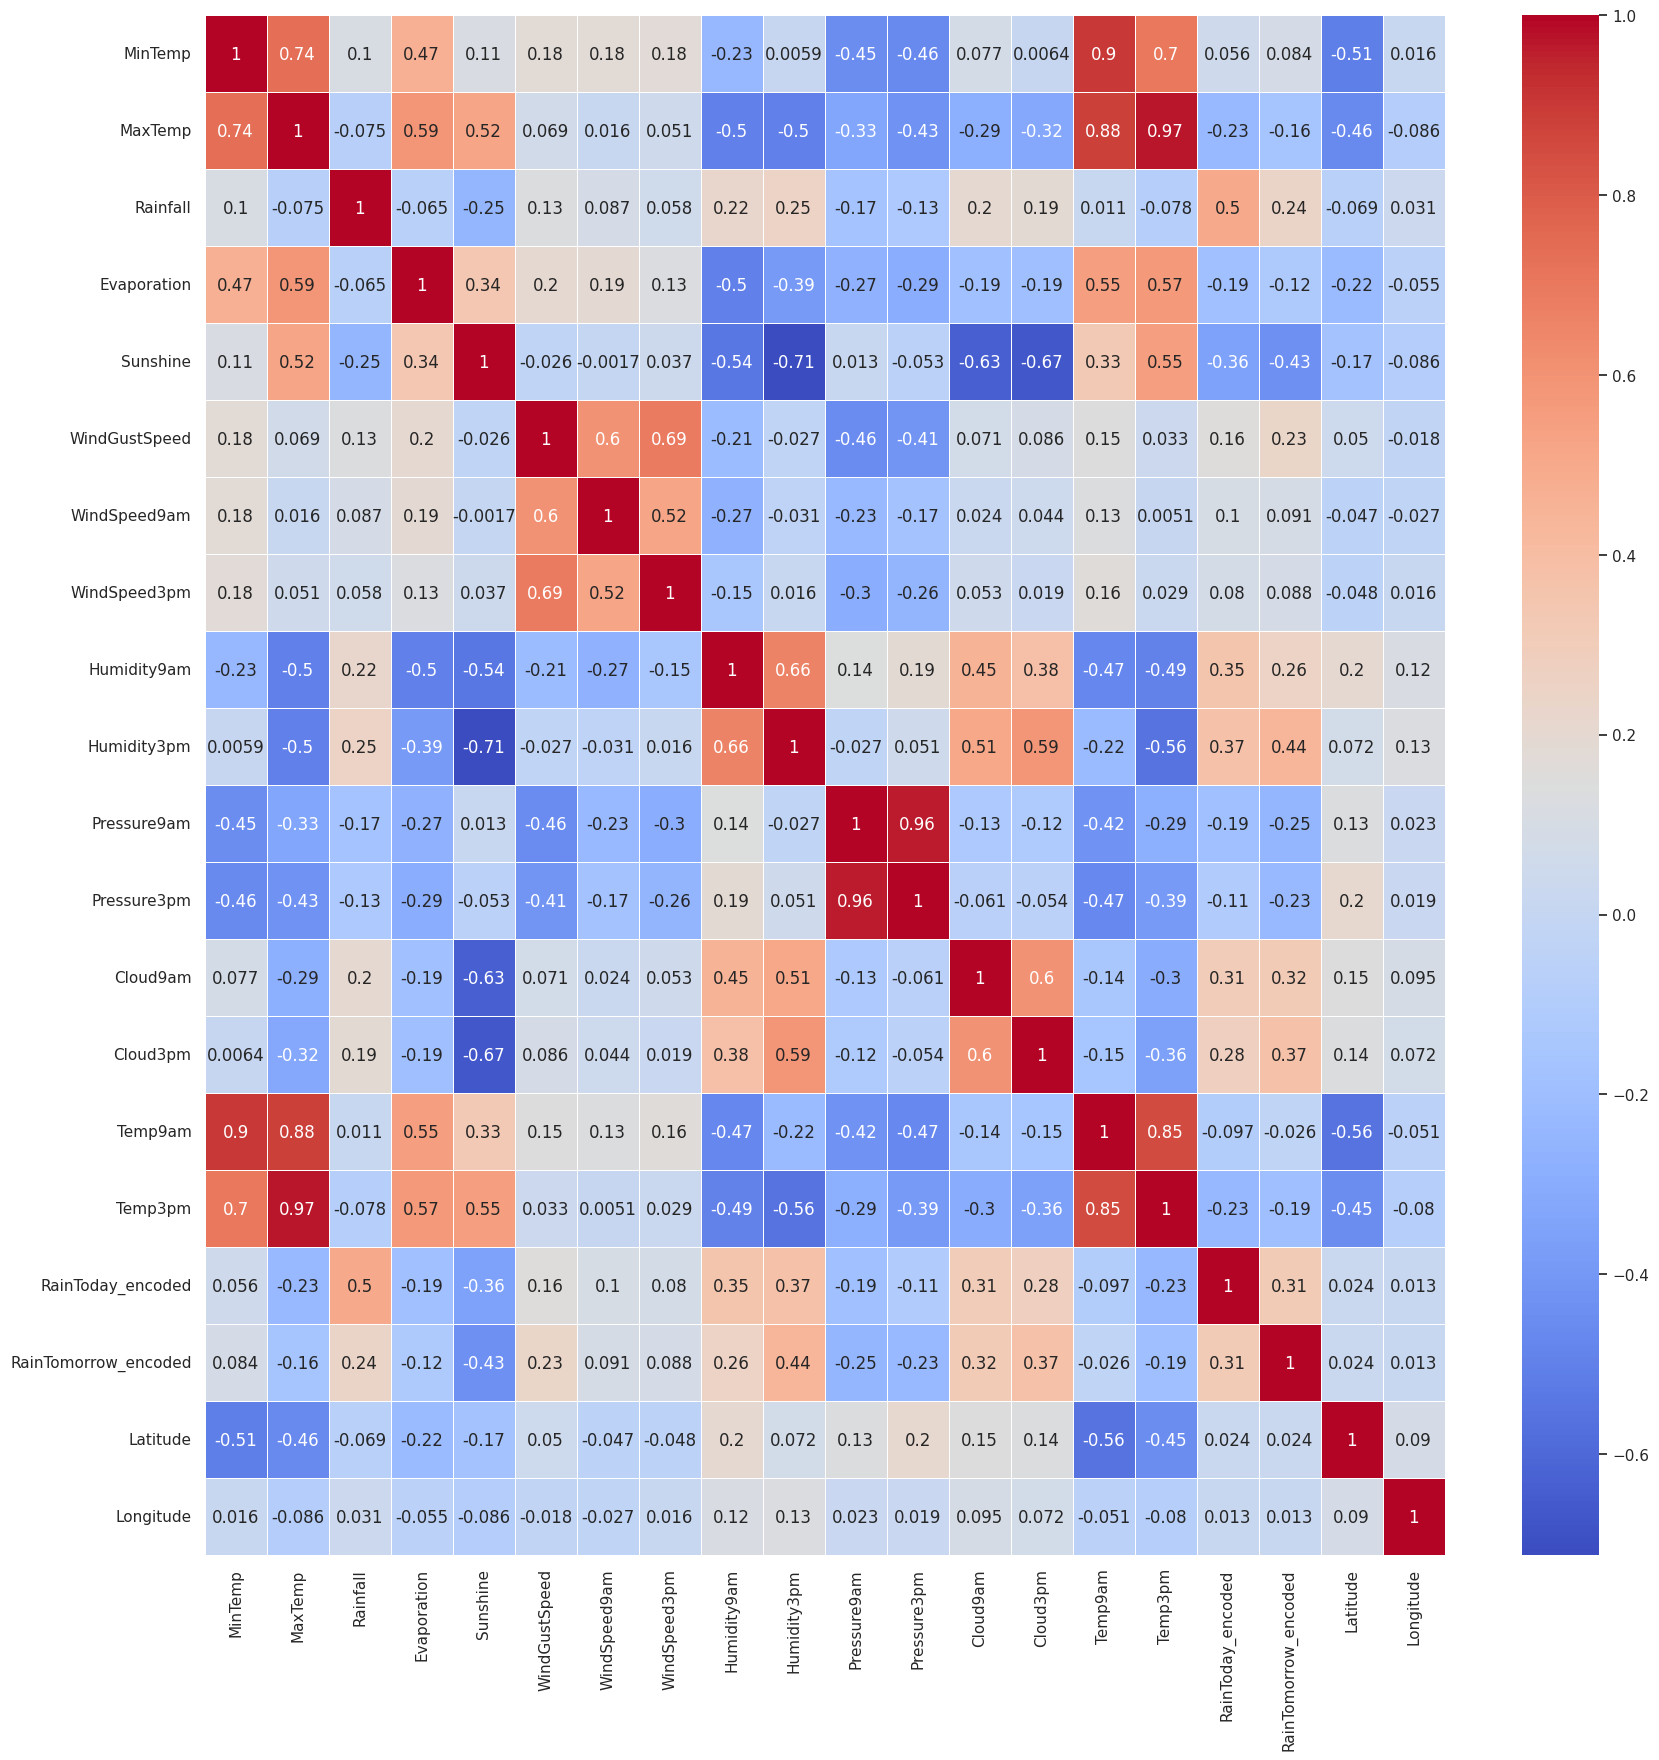

In [ ]:
plt.figure(figsize=(20, 20))
sns.heatmap(df.corr(), linewidths=0.5, annot=True, cmap="coolwarm")

In [ ]:
mat = pps.matrix(df)

<Axes: xlabel='x', ylabel='y'>

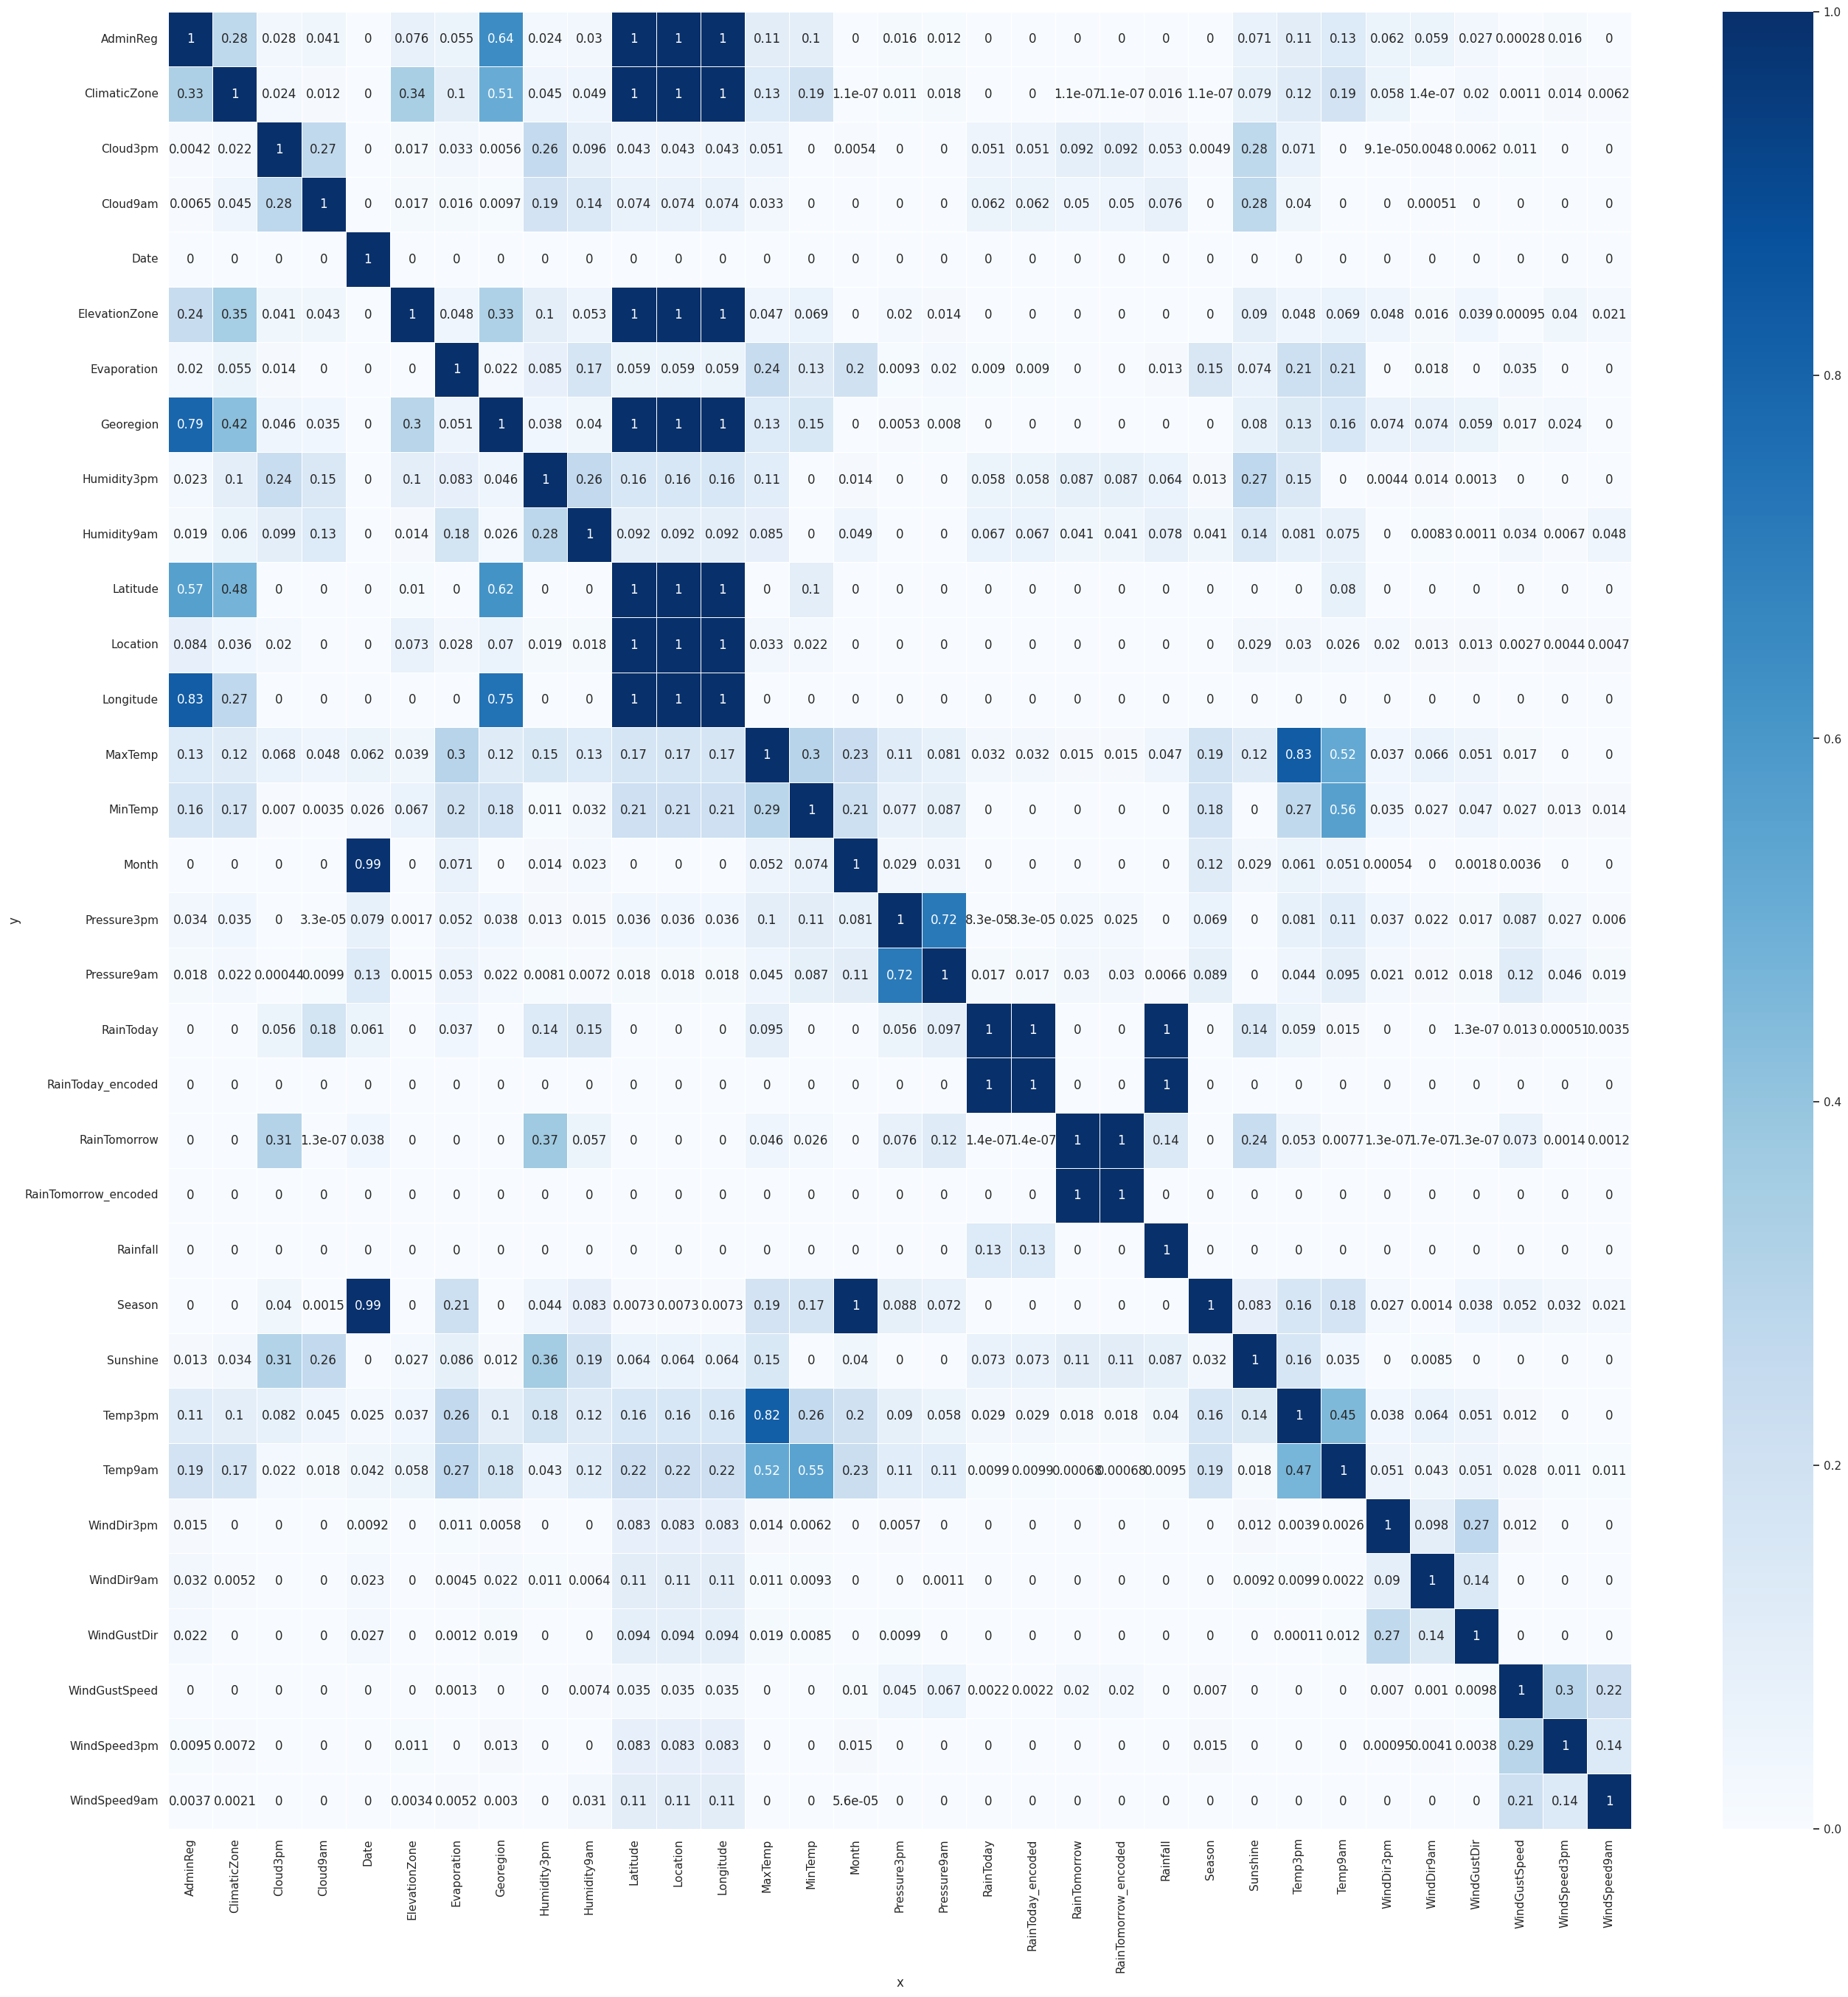

In [ ]:
plt.figure(figsize=(32, 32))
sns.heatmap(mat.pivot(columns='x', index='y', values='ppscore'),
            vmin=0, vmax=1, cmap="Blues", linewidths=0.5, annot=True)

In [ ]:
# Filter the matrix to show only the PPS scores for 'RainTomorrow' as target
matrix_raintom_filtered = mat[mat['y'] == 'RainTomorrow']
table = pd.DataFrame(matrix_raintom_filtered)
sorted_table = table[['x', 'y', 'ppscore']].sort_values(by='ppscore', ascending=False)
sorted_table['pers'] = round(sorted_table['ppscore']*100, 2)
print(sorted_table)

                         x             y       ppscore    pers
814   RainTomorrow_encoded  RainTomorrow  1.000000e+00  100.00
748           RainTomorrow  RainTomorrow  1.000000e+00  100.00
484            Humidity3pm  RainTomorrow  3.712154e-01   37.12
616               Cloud3pm  RainTomorrow  3.050011e-01   30.50
220               Sunshine  RainTomorrow  2.352388e-01   23.52
154               Rainfall  RainTomorrow  1.435209e-01   14.35
517            Pressure9am  RainTomorrow  1.204567e-01   12.05
550            Pressure3pm  RainTomorrow  7.579485e-02    7.58
286          WindGustSpeed  RainTomorrow  7.293057e-02    7.29
451            Humidity9am  RainTomorrow  5.739482e-02    5.74
682                Temp3pm  RainTomorrow  5.265493e-02    5.27
121                MaxTemp  RainTomorrow  4.586468e-02    4.59
22                    Date  RainTomorrow  3.837441e-02    3.84
88                 MinTemp  RainTomorrow  2.559019e-02    2.56
649                Temp9am  RainTomorrow  7.715594e-03 

**Note**: Probably could get read of Evaporation since the high loss and little influence

## Shortlisting important features:

In [ ]:
sorted_table = sorted_table[sorted_table['ppscore'] > 0.005]
sorted_table = sorted_table[sorted_table['ppscore'] < 1]
print(sorted_table)

                 x             y   ppscore   pers
484    Humidity3pm  RainTomorrow  0.371215  37.12
616       Cloud3pm  RainTomorrow  0.305001  30.50
220       Sunshine  RainTomorrow  0.235239  23.52
154       Rainfall  RainTomorrow  0.143521  14.35
517    Pressure9am  RainTomorrow  0.120457  12.05
550    Pressure3pm  RainTomorrow  0.075795   7.58
286  WindGustSpeed  RainTomorrow  0.072931   7.29
451    Humidity9am  RainTomorrow  0.057395   5.74
682        Temp3pm  RainTomorrow  0.052655   5.27
121        MaxTemp  RainTomorrow  0.045865   4.59
22            Date  RainTomorrow  0.038374   3.84
88         MinTemp  RainTomorrow  0.025590   2.56
649        Temp9am  RainTomorrow  0.007716   0.77


# Imputation

## Numerical Variables:
- MinTemp: mean
- MaxTemp: median

- Temp9am, Temp3pm: median

- Rainfall, Evaporation: median imputation due to skeweness distributions, outliers and little missed values.

- **Sunshine**: could be median, or more sophisticated method ( like regression imputation or KNN ) since there's a clear relationship with target variable. Zero imputation might also be vorking.

- WindGustSpeed, WindSpeed9am, WindSpeed3pm: median

- Humidity9am, Humidity3pm: median

- Pressure9am, Pressure3pm: mean

- Cloud9am: median
- **Cloud3pm**: KNN / Regression imputation

## Categorical Variables:
- WindGustDir, WindDir9am, WindDir3pm: mode
- RainToday: mode

## Imputing Sunshine and Cloud3pm using KNN

In [ ]:
df[['Sunshine', 'Cloud3pm']].describe()

,Sunshine,Cloud3pm
count,74377.000000,85099.000000
mean,7.624853,4.503167
std,3.781525,2.720633
min,0.000000,0.000000
25%,4.900000,2.000000
50%,8.500000,5.000000
75%,10.600000,7.000000
max,14.500000,9.000000


TODO:
- identify another correlatable features with Cloud and Sunshine

## Imputing Cloud3pm

In [25]:
df['Humidity9am'].fillna(df['Humidity9am'].median(), inplace=True)
df['Humidity3pm'].fillna(df['Humidity3pm'].median(), inplace=True)
df['Temp9am'].fillna(df['Temp9am'].median(), inplace=True)
df['Temp3pm'].fillna(df['Temp3pm'].median(), inplace=True)
df['MaxTemp'].fillna(df['MaxTemp'].median(), inplace=True)

In [30]:
features_for_imputation = ['Cloud3pm', 'Cloud9am', 'MaxTemp', 'Humidity3pm', 'Humidity9am', 'Temp3pm']
df_for_imputation = df[features_for_imputation].copy()
df_for_imputation.head()

,Cloud3pm,Cloud9am,MaxTemp,Humidity3pm,Humidity9am,Temp3pm
0,NaN,8.0,22.9,22.0,71.0,21.8
1,NaN,NaN,25.1,25.0,44.0,24.3
2,2.0,NaN,25.7,30.0,38.0,23.2
3,NaN,NaN,28.0,16.0,45.0,26.5
4,8.0,7.0,32.3,33.0,82.0,29.7


In [32]:
# Create a KNN imputer
imputer = KNNImputer(n_neighbors=5)

# Fit and transform the data to impute missing values
df_imputed = pd.DataFrame(imputer.fit_transform(df_for_imputation), columns=features_for_imputation, index=df_for_imputation.index)

In [33]:
df['Cloud3pm'] = df_imputed['Cloud3pm']

In [34]:
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,RainToday_encoded,RainTomorrow_encoded,Georegion,ElevationZone,ClimaticZone,AdminReg,Latitude,Longitude,Month,Season
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,5.0,16.9,21.8,No,No,0.0,0.0,Southeastern Australia,Lowland,Temperate,New South Wales,36.074,146.924,December,Winter
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,1.2,17.2,24.3,No,No,0.0,0.0,Southeastern Australia,Lowland,Temperate,New South Wales,36.074,146.924,December,Winter
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No,0.0,0.0,Southeastern Australia,Lowland,Temperate,New South Wales,36.074,146.924,December,Winter
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,NaN,2.8,18.1,26.5,No,No,0.0,0.0,Southeastern Australia,Lowland,Temperate,New South Wales,36.074,146.924,December,Winter
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No,0.0,0.0,Southeastern Australia,Lowland,Temperate,New South Wales,36.074,146.924,December,Winter


## Imputing Sunshine

In [38]:
# Select the features to use for imputation (NO2 and its correlated features)
features_for_imputation = ['Sunshine', 'Cloud3pm', 'Cloud9am', 'Humidity3pm', 'Humidity9am', 'Temp3pm', 'Temp9am', 'MaxTemp']
df_for_imputation = df[features_for_imputation].copy()
df_for_imputation.head()

,Sunshine,Cloud3pm,Cloud9am,Humidity3pm,Humidity9am,Temp3pm,Temp9am,MaxTemp
0,NaN,5.0,8.0,22.0,71.0,21.8,16.9,22.9
1,NaN,1.2,NaN,25.0,44.0,24.3,17.2,25.1
2,NaN,2.0,NaN,30.0,38.0,23.2,21.0,25.7
3,NaN,2.8,NaN,16.0,45.0,26.5,18.1,28.0
4,NaN,8.0,7.0,33.0,82.0,29.7,17.8,32.3


In [39]:
df_for_imputation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 141006 entries, 0 to 141005
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Sunshine     74351 non-null   float64
 1   Cloud3pm     141006 non-null  float64
 2   Cloud9am     88155 non-null   float64
 3   Humidity3pm  141006 non-null  float64
 4   Humidity9am  141006 non-null  float64
 5   Temp3pm      141006 non-null  float64
 6   Temp9am      141006 non-null  float64
 7   MaxTemp      141006 non-null  float64
dtypes: float64(8)
memory usage: 8.6 MB


In [40]:
df.tail()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,RainToday_encoded,RainTomorrow_encoded,Georegion,ElevationZone,ClimaticZone,AdminReg,Latitude,Longitude,Month,Season
141001,2017-06-20,Uluru,3.5,21.8,0.0,NaN,NaN,E,31.0,ESE,E,15.0,13.0,59.0,27.0,1024.7,1021.2,NaN,2.8,9.4,20.9,No,No,0.0,0.0,Central Australia,Plateau,Desert,Northern Territory,25.3444,131.0369,June,Summer
141002,2017-06-21,Uluru,2.8,23.4,0.0,NaN,NaN,E,31.0,SE,ENE,13.0,11.0,51.0,24.0,1024.6,1020.3,NaN,1.0,10.1,22.4,No,No,0.0,0.0,Central Australia,Plateau,Desert,Northern Territory,25.3444,131.0369,June,Summer
141003,2017-06-22,Uluru,3.6,25.3,0.0,NaN,NaN,NNW,22.0,SE,N,13.0,9.0,56.0,21.0,1023.5,1019.1,NaN,1.2,10.9,24.5,No,No,0.0,0.0,Central Australia,Plateau,Desert,Northern Territory,25.3444,131.0369,June,Summer
141004,2017-06-23,Uluru,5.4,26.9,0.0,NaN,NaN,N,37.0,SE,WNW,9.0,9.0,53.0,24.0,1021.0,1016.8,NaN,0.4,12.5,26.1,No,No,0.0,0.0,Central Australia,Plateau,Desert,Northern Territory,25.3444,131.0369,June,Summer
141005,2017-06-24,Uluru,7.8,27.0,0.0,NaN,NaN,SE,28.0,SSE,N,13.0,7.0,51.0,24.0,1019.4,1016.5,3.0,2.0,15.1,26.0,No,No,0.0,0.0,Central Australia,Plateau,Desert,Northern Territory,25.3444,131.0369,June,Summer


In [41]:
df_for_imputation.tail()

,Sunshine,Cloud3pm,Cloud9am,Humidity3pm,Humidity9am,Temp3pm,Temp9am,MaxTemp
141001,NaN,2.8,NaN,27.0,59.0,20.9,9.4,21.8
141002,NaN,1.0,NaN,24.0,51.0,22.4,10.1,23.4
141003,NaN,1.2,NaN,21.0,56.0,24.5,10.9,25.3
141004,NaN,0.4,NaN,24.0,53.0,26.1,12.5,26.9
141005,NaN,2.0,3.0,24.0,51.0,26.0,15.1,27.0


excluding Evaporatio because of huge loss of entries

In [42]:
# Fit and transform the data to impute missing values
df_imputed = pd.DataFrame(imputer.fit_transform(df_for_imputation), columns=features_for_imputation, index=df_for_imputation.index)

In [43]:
df['Sunshine'] = df_imputed['Sunshine']

## Imputing the rest features:

In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 141006 entries, 0 to 141005
Data columns (total 33 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   Date                  141006 non-null  datetime64[ns]
 1   Location              141006 non-null  object        
 2   MinTemp               140731 non-null  float64       
 3   MaxTemp               141006 non-null  float64       
 4   Rainfall              139845 non-null  float64       
 5   Evaporation           81313 non-null   float64       
 6   Sunshine              141006 non-null  float64       
 7   WindGustDir           132680 non-null  object        
 8   WindGustSpeed         132738 non-null  float64       
 9   WindDir9am            132066 non-null  object        
 10  WindDir3pm            138181 non-null  object        
 11  WindSpeed9am          140416 non-null  float64       
 12  WindSpeed3pm          139318 non-null  float64       
 13 

In [45]:
# Impute values median
df['Rainfall'].fillna(df['Rainfall'].median(), inplace=True)
df['WindGustSpeed'].fillna(df['WindGustSpeed'].median(), inplace=True)
df['Evaporation'].fillna(df['Evaporation'].median(), inplace=True)
df['Cloud9am'].fillna(df['Cloud9am'].median(), inplace=True)
df['WindSpeed9am'].fillna(df['WindSpeed9am'].median(), inplace=True)
df['WindSpeed3pm'].fillna(df['WindSpeed3pm'].median(), inplace=True)

# impute values mean
df['MinTemp'].fillna(df['MinTemp'].mean(), inplace=True)
df['Pressure9am'].fillna(df['Pressure9am'].mean(), inplace=True)
df['Pressure3pm'].fillna(df['Pressure3pm'].mean(), inplace=True)

In [47]:
## impute categorical values with mode
df['WindGustDir'].fillna(df['WindGustDir'].mode()[0], inplace=True)
df['WindDir9am'].fillna(df['WindDir9am'].mode()[0], inplace=True)
df['WindDir3pm'].fillna(df['WindDir3pm'].mode()[0], inplace=True)
df['RainToday'].fillna(df['RainToday'].mode()[0], inplace=True)

In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 141006 entries, 0 to 141005
Data columns (total 31 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   Date                  141006 non-null  datetime64[ns]
 1   Location              141006 non-null  object        
 2   MinTemp               141006 non-null  float64       
 3   MaxTemp               141006 non-null  float64       
 4   Rainfall              141006 non-null  float64       
 5   Sunshine              141006 non-null  float64       
 6   WindGustDir           141006 non-null  object        
 7   WindGustSpeed         141006 non-null  float64       
 8   WindDir9am            141006 non-null  object        
 9   WindDir3pm            141006 non-null  object        
 10  WindSpeed9am          141006 non-null  float64       
 11  WindSpeed3pm          141006 non-null  float64       
 12  Humidity9am           141006 non-null  float64       
 13 

In [58]:
yes_no_mapping = {'Yes': 1, 'No': 0}
df['RainTomorrow_encoded'] = df['RainTomorrow'].map(yes_no_mapping)
df['RainToday_encoded'] = df['RainToday'].map(yes_no_mapping)

In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 141006 entries, 0 to 141005
Data columns (total 31 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   Date                  141006 non-null  datetime64[ns]
 1   Location              141006 non-null  object        
 2   MinTemp               141006 non-null  float64       
 3   MaxTemp               141006 non-null  float64       
 4   Rainfall              141006 non-null  float64       
 5   Sunshine              141006 non-null  float64       
 6   WindGustDir           141006 non-null  object        
 7   WindGustSpeed         141006 non-null  float64       
 8   WindDir9am            141006 non-null  object        
 9   WindDir3pm            141006 non-null  object        
 10  WindSpeed9am          141006 non-null  float64       
 11  WindSpeed3pm          141006 non-null  float64       
 12  Humidity9am           141006 non-null  float64       
 13 

In [62]:
download = df.to_csv('df_imputed.csv', index=False)
files.download('df_imputed.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Handling outliers

In [64]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
MinTemp,141006.0,12.191376,6.395593,-8.5000,7.6000,12.000000,16.8000,33.9000
MaxTemp,141006.0,23.236040,7.110225,-4.8000,17.9000,22.600000,28.2000,48.1000
Rainfall,141006.0,2.323418,8.392177,0.0000,0.0000,0.000000,0.6000,371.0000
Sunshine,141006.0,7.440724,3.550288,0.0000,4.8000,8.100000,10.3000,14.5000
WindGustSpeed,141006.0,39.922032,13.183587,6.0000,31.0000,39.000000,46.0000,135.0000
WindSpeed9am,141006.0,14.025793,8.858030,0.0000,7.0000,13.000000,19.0000,130.0000
WindSpeed3pm,141006.0,18.646611,8.748987,0.0000,13.0000,19.000000,24.0000,87.0000
Humidity9am,141006.0,68.835234,18.973412,0.0000,57.0000,70.000000,83.0000,100.0000
Humidity3pm,141006.0,51.469845,20.578945,0.0000,37.0000,52.000000,65.0000,100.0000
Pressure9am,141006.0,1017.653525,6.772852,980.5000,1013.5000,1017.653525,1021.9000,1041.0000


## Rainfall

<Axes: xlabel='Rainfall', ylabel='Count'>

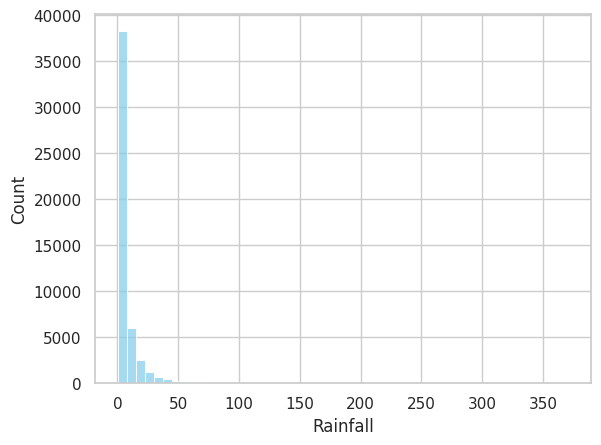

In [87]:
sns.histplot(df[df["Rainfall"]>0]["Rainfall"], bins=50, kde=False, color='skyblue')

In [89]:
ninety_ninth_quartile_rainfall = df['Rainfall'].quantile(0.99)
print(f"The 99th quartile of Rainfall values is: {ninety_ninth_quartile_rainfall}")

The 99th quartile of Rainfall values is: 37.0


In [90]:
len(df[df["Rainfall"]>37]["Rainfall"])

1410

In [91]:
# Cap the top 1% of Rainfall values to 37
df['Rainfall'] = np.where(df['Rainfall'] > ninety_ninth_quartile_rainfall, ninety_ninth_quartile_rainfall, df['Rainfall'])

In [92]:
df['Rainfall'].describe()

,Rainfall
count,141006.000000
mean,2.057411
std,5.808575
min,0.000000
25%,0.000000
50%,0.000000
75%,0.600000
max,37.000000


<Axes: xlabel='Rainfall', ylabel='Count'>

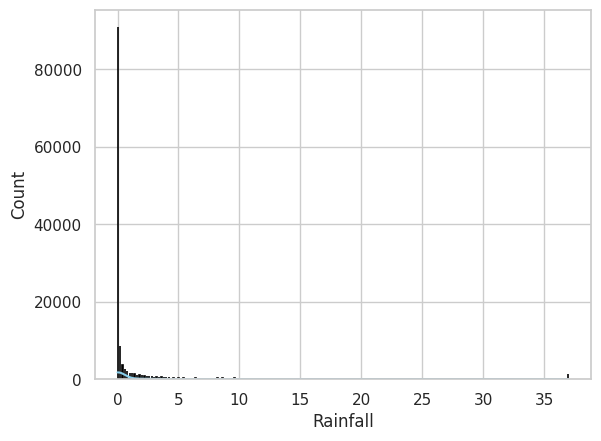

In [94]:
sns.histplot(df['Rainfall'], kde=True, color='skyblue', linewidth=1.2, edgecolor='black')

## WindGustSpeed

In [96]:
df[['WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm']].describe()

,WindGustSpeed,WindSpeed9am,WindSpeed3pm
count,141006.000000,141006.000000,141006.000000
mean,39.922032,14.025793,18.646611
std,13.183587,8.858030,8.748987
min,6.000000,0.000000,0.000000
25%,31.000000,7.000000,13.000000
50%,39.000000,13.000000,19.000000
75%,46.000000,19.000000,24.000000
max,135.000000,130.000000,87.000000


<Axes: xlabel='WindGustSpeed', ylabel='Count'>

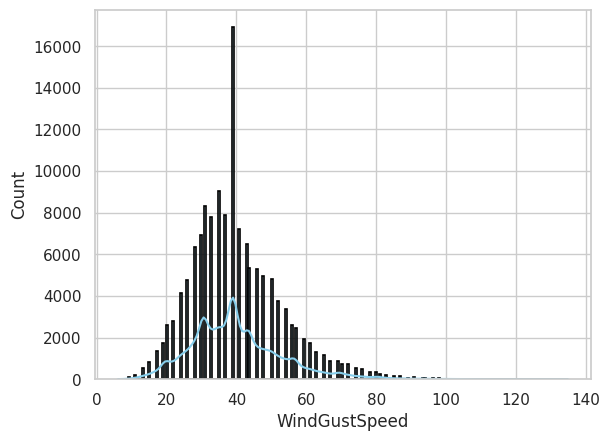

In [97]:
sns.histplot(df['WindGustSpeed'], kde=True, color='skyblue', linewidth=1.2, edgecolor='black')

In [101]:
df['WindGustSpeed'].mode()

,WindGustSpeed
0,39.0


In [103]:
ninety_ninth_quartile_windgust = df['WindGustSpeed'].quantile(0.99)
print(f"The 99th quartile of WindGustSpeed values is: {ninety_ninth_quartile_windgust}")

The 99th quartile of WindGustSpeed values is: 80.0


In [104]:
# cap on WindGustSpeed
df['WindGustSpeed'] = np.where(df['WindGustSpeed'] > ninety_ninth_quartile_windgust, ninety_ninth_quartile_windgust, df['WindGustSpeed'])

In [105]:
df['WindGustSpeed'].describe()

,WindGustSpeed
count,141006.000000
mean,39.836553
std,12.865099
min,6.000000
25%,31.000000
50%,39.000000
75%,46.000000
max,80.000000


## Temp3pm, MaxTemp

<Axes: xlabel='Temp3pm', ylabel='Count'>

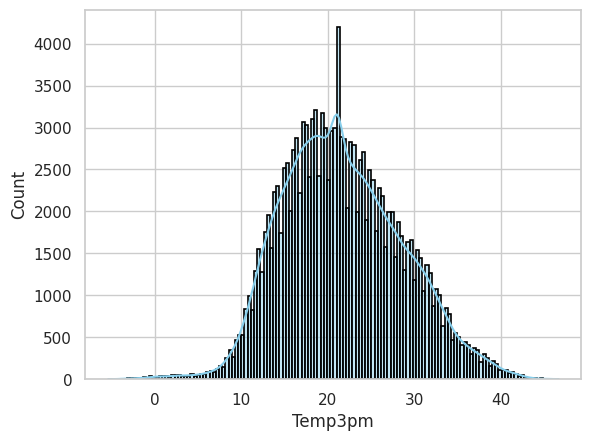

In [106]:
sns.histplot(df['Temp3pm'], kde=True, color='skyblue', linewidth=1.2, edgecolor='black')

## Evaporation

<Axes: xlabel='Evaporation', ylabel='Count'>

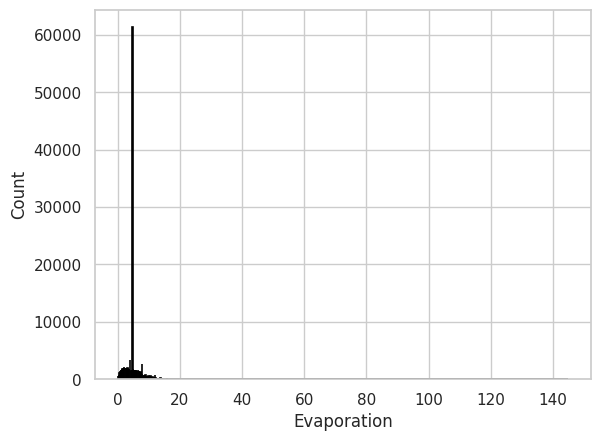

In [116]:
sns.histplot(df['Evaporation'], kde=False, color='skyblue', linewidth=1.2, edgecolor='black')

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


<Axes: xlabel='Evaporation'>

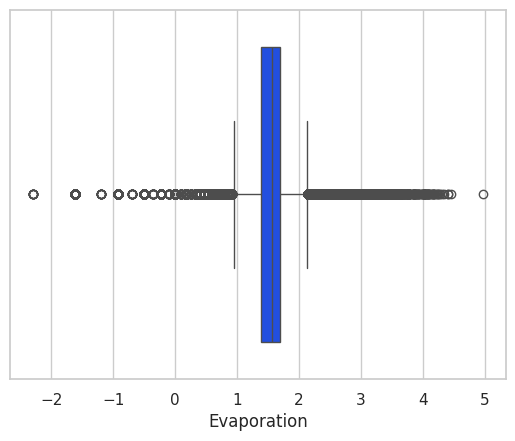

In [119]:
sns.boxplot(x=np.log(df['Evaporation']))

In [125]:
quantile_99_evaporation = df['Evaporation'].quantile(0.99)
quantile_99_evaporation

15.8

In [126]:
# cap on Evaporation
df['Evaporation'] = np.where(df['Evaporation'] > quantile_99_evaporation, quantile_99_evaporation, df['Evaporation'])

# Normalization

In [129]:
download = df.to_csv('df_before_normalization.csv', index=False)
files.download('df_before_normalization.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [130]:
# numerical features for normalization
continuous_features = ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed',
                      'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am',
                      'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 'Latitude', 'Longitude']

# StandardScaler object
scaler = StandardScaler()

df[continuous_features] = scaler.fit_transform(df[continuous_features])

In [134]:
df_2016 = df[df['Date'].dt.year.isin([2016])]
len(df_2016)

17292

In [ ]:
df_2016.set_index('Date', inplace=True)

In [142]:
plt.figure(figsize=(40, 15))
sns.lineplot(df_2016[continuous_features])

Output hidden; open in https://colab.research.google.com to view.

In [143]:
download = df.to_csv('df_prepared.csv', index=False)
files.download('df_prepared.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# TODO: Encoding

In [127]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 141006 entries, 0 to 141005
Data columns (total 33 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   Date                  141006 non-null  datetime64[ns]
 1   Location              141006 non-null  object        
 2   MinTemp               141006 non-null  float64       
 3   MaxTemp               141006 non-null  float64       
 4   Rainfall              141006 non-null  float64       
 5   Sunshine              141006 non-null  float64       
 6   WindGustDir           141006 non-null  object        
 7   WindGustSpeed         141006 non-null  float64       
 8   WindDir9am            141006 non-null  object        
 9   WindDir3pm            141006 non-null  object        
 10  WindSpeed9am          141006 non-null  float64       
 11  WindSpeed3pm          141006 non-null  float64       
 12  Humidity9am           141006 non-null  float64       
 13 